# Course project

This notebook includes the steps to optimize the capacity and dispatch of generators in a stylized energy system. It has been prepared to serve as a tutorial for a simple PyPSA model representing the energy system in one country, city or region. 
 

For the (optional) project of the course [Integrated Energy Grids](https://kurser.dtu.dk/course/2024-2025/46770?menulanguage=en) you need to deliver a report including the sections described at the end of this notebook.

Please, review the [PyPSA tutorial](https://martavp.github.io/integrated-energy-grids/intro-pypsa.html) before starting this project.

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `pypsa` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

In [4]:
!pip install pypsa



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import pypsa

We start by creating the network. In this example, the country is modelled as a single node, so the network includes only one bus.

We select the year 2015 and set the hours in that year as snapshots.

We select a country, in this case Denmark (DNK), and add one node (electricity bus) to the network.

In [6]:
network = pypsa.Network()
hours_in_2017 = pd.date_range('2017-01-01 00:00Z',
                              '2017-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2017.values)

network.add("Bus",
            "electricity bus")


network.add("Bus",
            "electricity bus GERMANY")

network.add("Bus",
            "electricity bus BELGIUM")

network.snapshots


DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2017-12-31 14:00:00', '2017-12-31 15:00:00',
               '2017-12-31 16:00:00', '2017-12-31 17:00:00',
               '2017-12-31 18:00:00', '2017-12-31 19:00:00',
               '2017-12-31 20:00:00', '2017-12-31 21:00:00',
               '2017-12-31 22:00:00', '2017-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

The demand is represented by the historical electricity demand in 2015 with hourly resolution.

The file with historical hourly electricity demand for every European country is available in the data folder.

The electricity demand time series were obtained from ENTSOE through the very convenient compilation carried out by the Open Power System Data (OPSD). https://data.open-power-system-data.org/time_series/

In [7]:
# load electricity demand data
df_elec = pd.read_csv('electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='NLD'
country2 = 'DEU'
country3 = 'BEL'
print(df_elec[country].head())

utc_time
2015-01-01 00:00:00+00:00    11338.0
2015-01-01 01:00:00+00:00    10917.0
2015-01-01 02:00:00+00:00    10473.0
2015-01-01 03:00:00+00:00    10200.0
2015-01-01 04:00:00+00:00    10182.0
Name: NLD, dtype: float64


In [8]:
nodes = pd.Series(['NLD','DEU','BEL']).values

# longitude
xs = {'NLD':5.291266,
     'DEU':10.451526,
     'BEL':4.469936}

# latitude
ys = {'NLD':52.132633,
     'DEU':51.165691,
     'BEL':50.503887}

network.add("Bus",'NLD',x=xs['NLD'],y=ys['NLD'])
network.add("Bus",'DEU',x=xs['DEU'],y=ys['DEU'])
network.add("Bus",'BEL',x=xs['BEL'],y=ys['BEL'])

Index(['BEL'], dtype='object')

In [9]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)

network.add("Load",
            "load",
            bus="electricity bus GERMANY",
            p_set=df_elec[country2].values)

network.add("Load",
            "load",
            bus="electricity bus BELGIUM",
            p_set=df_elec[country3].values)

network.add("Link",
             'country - country2',
             bus0="electricity bus",
             bus1="electricity bus GERMANY",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             length=600, # length (in km) between country a and country b
             capital_cost=400*600) # capital cost * length

network.add("Link",
             'country - country3',
             bus0="electricity bus",
             bus1="electricity bus BELGIUM",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             length=600, # length (in km) between country a and country b
             capital_cost=400*600) # capital cost * length



Index(['country - country3'], dtype='object')

Print the load time series to check that it has been properly added (you should see numbers and not 'NaN')

In [10]:
network.loads_t.p_set

Load,load
snapshot,
2017-01-01 00:00:00,11338.0
2017-01-01 01:00:00,10917.0
2017-01-01 02:00:00,10473.0
2017-01-01 03:00:00,10200.0
2017-01-01 04:00:00,10182.0
...,...
2017-12-31 19:00:00,12958.0
2017-12-31 20:00:00,12263.0
2017-12-31 21:00:00,11772.0


In the optimization, we will minimize the annualized system costs.

We will need to annualize the cost of every generator, we build a function to do it.

In [11]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


We include solar PV and onshore wind generators.

The capacity factors representing the availability of those generators for every European country can be downloaded from the following repositories (select 'optimal' for PV and onshore for wind).

https://zenodo.org/record/3253876#.XSiVOEdS8l0

https://zenodo.org/record/2613651#.XSiVOkdS8l0

We include also Open Cycle Gas Turbine (OCGT) generators

The cost assumed for the generators are the same as in Table 1 in the paper https://doi.org/10.1016/j.enconman.2019.111977 (open version:  https://arxiv.org/pdf/1906.06936.pdf)

In [12]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

# add onshore wind generator
df_onshorewind = pd.read_csv('onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
#the capacity factor is being extracted with this line above
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW, this is a formula to calculate annuality in function of years, interest, investment costs and a fix factor
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values, overwrite=True)

network.add("Generator",
            "onshorewind",
            bus="electricity bus GERMANY",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values, overwrite=True)

network.add("Generator",
            "onshorewind",
            bus="electricity bus BELGIUM",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values, overwrite=True)


# add solar PV generator
df_solar = pd.read_csv('pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values, overwrite=True)

network.add("Generator",
            "solar",
            bus="electricity bus GERMANY",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values, overwrite=True)

network.add("Generator",
            "solar",
            bus="electricity bus BELGIUM",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values, overwrite=True)



# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 20.1 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT, overwrite=True)

network.add("Generator",
            "OCGT",
            bus="electricity bus GERMANY",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT, overwrite=True)

network.add("Generator",
            "OCGT",
            bus="electricity bus BELGIUM",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT, overwrite=True)



# THIS IS FOR QUESTION C
#avg_CF_wind = CF_wind.mean()
#avg_CF_solar = CF_solar.mean()
#print(f"Average Capacity Factor for Solar : {avg_CF_solar:.2%}")
#print(f"Average Capacity Factor for Onshore Wind: {avg_CF_wind:.2%}")
#print(CF_wind)

#annual_mean_pv = df_solar[country].resample('YE').mean()
#annual_mean_pv.plot(kind='line', ylabel='Capacity Factor solar PV', color='orange')
#print('Average solar annual mean {:.2f}, \nNormalized Standar deviation {:.2f} %'.format(annual_mean_pv.mean(),annual_mean_pv.std()/annual_mean_pv.mean()))

#annual_mean_wind = df_onshorewind[country].resample('YE').mean()
#annual_mean_wind.plot(kind='line', ylabel='Capacity Factor onshore wind')
#print('Average wind annual mean {:.2f}, \nNormalized Standar deviation {:.2f} %'.format(annual_mean_wind.mean(),annual_mean_wind.std()/annual_mean_wind.mean()))


Index(['OCGT'], dtype='object')

In [13]:
CF_wind = pd.DataFrame()
CF_solar = pd.DataFrame()
for i in range(len(nodes)):
    CF_wind[nodes[i]] = df_onshorewind[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    CF_solar[nodes[i]] = df_solar[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

In [14]:
network.optimize()

Index(['country - country2', 'country - country3'], dtype='object', name='Link')
Index(['electricity bus', 'electricity bus GERMANY', 'electricity bus BELGIUM',
       'NLD', 'DEU', 'BEL'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 41.24it/s]
INFO:linopy.io: Writing time: 0.75s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 113885 duals
Objective: 1.05e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [18]:
print(network.objective/1000000) #in 10^6 €

10507.13942944512


In [19]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    92.778374
dtype: float64


In [20]:
network.generators.p_nom_opt # in MW

Generator
onshorewind    18163.299663
solar          17816.183687
OCGT           17460.040404
Name: p_nom_opt, dtype: float64

In [16]:
!pip install Plotting


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

# Crear un DataFrame con las coordenadas
nodes = pd.Series(['NLD', 'DEU', 'BEL']).values
xs = {'NLD': 5.291266, 'DEU': 10.451526, 'BEL': 4.469936}
ys = {'NLD': 52.132633, 'DEU': 51.165691, 'BEL': 50.503887}

# Crear un DataFrame de puntos
points = pd.DataFrame({
    'Country': nodes,
    'Longitude': [xs[node] for node in nodes],
    'Latitude': [ys[node] for node in nodes],
    ''
})

# Crear una geometría de puntos
geometry = [Point(lon, lat) for lon, lat in zip(points['Longitude'], points['Latitude'])]

# Crear un GeoDataFrame
gdf = gpd.GeoDataFrame(points, geometry=geometry)



SyntaxError: ':' expected after dictionary key (1303798428.py, line 16)

In [32]:

# Cargar un shapefile de países
world = gpd.read_file('C:/Users/nadia/OneDrive/Documentos/Integrated energy grids/DATA ASSIGMENT/ne_110m_admin_0_countries')
europe = world[(world["CONTINENT"] == "Europe") & (world["NAME"] != "Russia")]
europe.to_file("europe.geojson", driver="GeoJSON")

INFO:pyogrio._io:Created 38 records


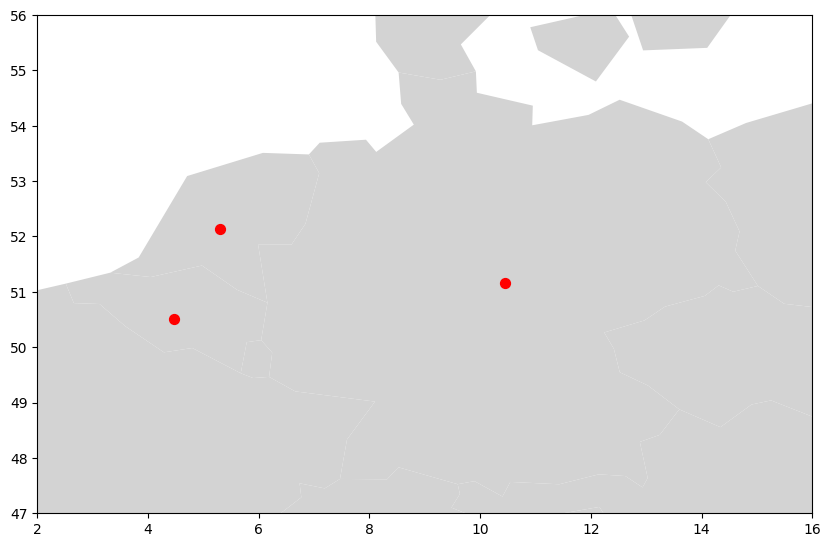

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
europe.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='red', markersize=50)
ax.set_xlim([2, 16]) #longitude range
ax.set_ylim([47, 56]) # latitude range
plt.show()

Print the generator Capacity factor time series to check that it has been properly added (you should see numbers and not 'NaN')

In [15]:
network.generators_t.p_max_pu

Generator,onshorewind,solar
snapshot,,
2017-01-01 00:00:00,0.350,0.0
2017-01-01 01:00:00,0.377,0.0
2017-01-01 02:00:00,0.385,0.0
2017-01-01 03:00:00,0.400,0.0
2017-01-01 04:00:00,0.406,0.0
...,...,...
2017-12-31 19:00:00,0.468,0.0
2017-12-31 20:00:00,0.595,0.0
2017-12-31 21:00:00,0.684,0.0


We find the optimal solution using Gurobi as solver.

In this case, we are optimizing the installed capacity and dispatch of every generator to minimize the total system cost.

The message ('ok' , 'optimal") indicates that the optimizer has found an optimal solution.

The total cost can be read from the network objetive.

In [16]:
print(network.objective/1000000) #in 10^6 €

10507.13942944512


The cost per MWh of electricity produced can also be calculated.

In [17]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    92.778374
dtype: float64


The optimal capacity for every generator can be shown.

In [18]:
network.generators.p_nom_opt # in MW

Generator
onshorewind    18163.299663
solar          17816.183687
OCGT           17460.040404
Name: p_nom_opt, dtype: float64

We can plot now the dispatch of every generator during the first week of the year and the electricity demand.
We import the matplotlib package which is very useful to plot results.

We can also plot the electricity mix.

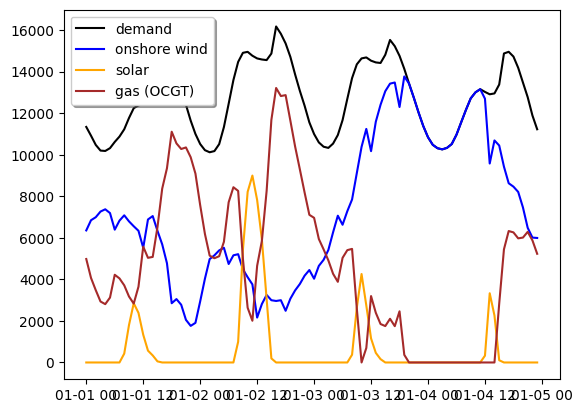

In [19]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

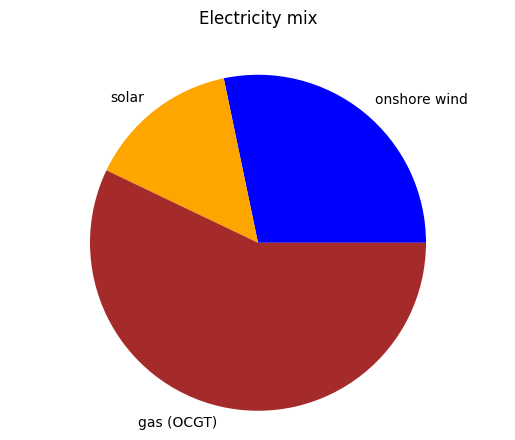

In [20]:
labels = ['onshore wind',
          'solar',
          'gas (OCGT)']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'orange', 'brown']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [21]:

# Define time ranges for summer and winter (assuming hourly data for a full year)
summer_week = pd.date_range("2005-07-01", periods=168, freq="h")
winter_week = pd.date_range("2005-01-01", periods=168, freq="h")

# Extract generation data for summer and winter weeks
dispatch_summer = network.generators_t.p.loc[summer_week]
dispatch_winter = network.generators_t.p.loc[winter_week]

# Plot summer dispatch
plt.figure(figsize=(12, 5))
plt.stackplot(dispatch_summer.index,
              dispatch_summer["onshorewind"],
              dispatch_summer["solar"],
              dispatch_summer["OCGT"],
              labels=["Onshore Wind", "Solar", "Gas (OCGT)"],
              colors=["blue", "orange", "brown"], alpha=0.7)
plt.plot(network.loads_t.p.loc[summer_week, 'load'], color='black', linestyle='-', linewidth=2, label='Demand')
plt.title("Energy Dispatch - Summer Week")
plt.xlabel("Date")
plt.ylabel("Power (MW)")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot winter dispatch
plt.figure(figsize=(12, 5))
plt.stackplot(dispatch_winter.index,
              dispatch_winter["onshorewind"],
              dispatch_winter["solar"],
              dispatch_winter["OCGT"],
              labels=["Onshore Wind", "Solar", "Gas (OCGT)"],
              colors=["blue", "orange", "brown"], alpha=0.7)
plt.plot(network.loads_t.p.loc[winter_week, 'load'], color='black', linestyle='-', linewidth=2, label='Demand')
plt.title("Energy Dispatch - Winter Week")
plt.xlabel("Date")
plt.ylabel("Power (MW)")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyError: "None of [DatetimeIndex(['2005-07-01 00:00:00', '2005-07-01 01:00:00',\n               '2005-07-01 02:00:00', '2005-07-01 03:00:00',\n               '2005-07-01 04:00:00', '2005-07-01 05:00:00',\n               '2005-07-01 06:00:00', '2005-07-01 07:00:00',\n               '2005-07-01 08:00:00', '2005-07-01 09:00:00',\n               ...\n               '2005-07-07 14:00:00', '2005-07-07 15:00:00',\n               '2005-07-07 16:00:00', '2005-07-07 17:00:00',\n               '2005-07-07 18:00:00', '2005-07-07 19:00:00',\n               '2005-07-07 20:00:00', '2005-07-07 21:00:00',\n               '2005-07-07 22:00:00', '2005-07-07 23:00:00'],\n              dtype='datetime64[ns]', length=168, freq='h')] are in the [index]"

We can add a global CO2 constraint and solve again.

In [ ]:
co2_limit=1000000 #tonCO2
#look at the emissions the netherlands emitted in 2015, and put a cap
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)
network.optimize()

Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.64it/s]
INFO:linopy.io: Writing time: 1.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 2.44e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [ ]:
network.generators.p_nom_opt #in MW

Generator
onshorewind    273144.976572
solar           71064.043179
OCGT            14954.550234
Name: p_nom_opt, dtype: float64

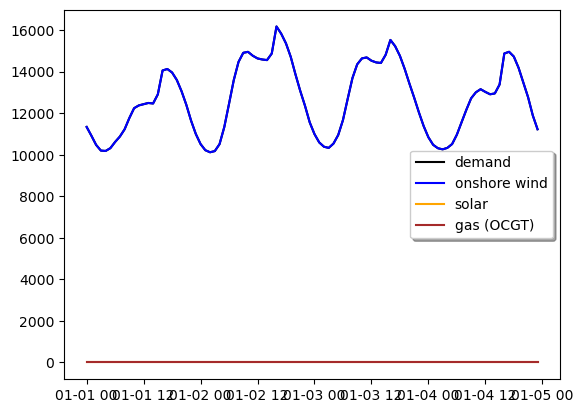

In [ ]:
plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

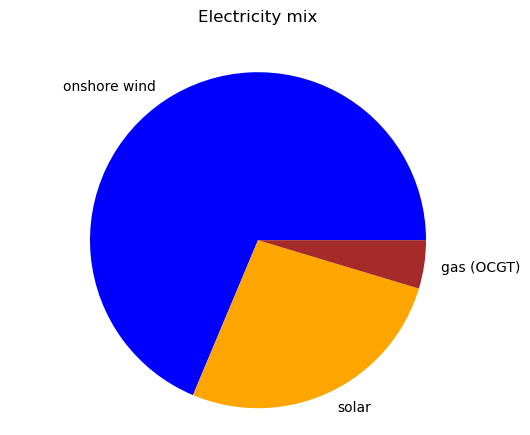

In [ ]:
labels = ['onshore wind', 'solar', 'gas (OCGT)' ]
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors = ['blue', 'orange', 'brown']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

# PROJECT INSTRUCTIONS


Based on the previous example, you are asked to carry out the following tasks:

A. Choose a different country/region/city/system and calculate the optimal capacities for renewable and non-renewable generators. You can add as many technologies as you want. Remember to provide a reference for the cost assumptions. Plot the dispatch time series for a week in summer and winter. Plot the annual electricity mix. Use the duration curves or the capacity factor to investigate the contribution of different technologies.

B. Investigate how sensitive the optimum capacity mix is to the global CO2 constraint. E.g., plot the generation mix as a function of the CO2 constraint that you impose. Search for the CO2 emissions in your country (today or in 1990) and refer to the emissions allowance to that historical data.

C. Investigate how sensitive your results are to the interannual variability of solar and wind generation. Plot the average capacity and variability obtained for every generator using different weather years.

D. Add some storage technology/ies and investigate how they behave and what their impact is on the optimal system configuration. Discuss what strategies is your system using to balance the renewable generation at different time scales (intraday, seasonal, etc.)

E. Select one target for decarbonization (i.e., one CO2 allowance limit). What is the CO2 price required to achieve that decarbonization level? Search for information on the existing CO2 tax in your country (if any) and discuss your results.

F. Connect your country with, at least, two neighbouring countries. You can connect them using HVAC lines, HVDC links or gas pipelines. Use a linear representation of power flow or gas flow. 
You can assume that the generation capacities in the neighbouring countries are fixed or optimize the whole system. You can also include fixed interconnection capacities or optimize them with the generators' capacities. Discuss your results.

G. Connect the electricity sector with, at least, another sector( e.g. heating or transport), and co-optimize all the sectors. Discuss your results.

H. Finally, select one topic that is under discussion in your region. Design and implement some experiment to obtain relevant information regarding that topic. E.g.

- What are the consequences if Denmark decides not to install more onshore wind?

- Would it be more expensive if France decides to close its nuclear power plants?

- What will be the main impacts of the Viking link?

- How does gas scarcity impact the optimal system configuration?

**Write a short report (maximum length 10 pages) in groups of 4 students including your main findings.**

# Hints

_HINT 1: You can add a link with the following code_

The efficiency will be 1 if you are connecting two countries and different from one if, for example, you are connecting the electricity bus to the heating bus using a heat pump.
Setting p_min_pu=-1 makes the link reversible.


In [ ]:
network.add("Link",
             'country a - country b',
             bus0="electricity bus country a",
             bus1="electricity bus country b",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             length=600, # length (in km) between country a and country b
             capital_cost=400*600) # capital cost * length

Index(['country a - country b'], dtype='object')
Index(['country a - country b'], dtype='object')


Index(['country a - country b'], dtype='object')

_HINT 2: You can check the KKT multiplier associated with the constraint with the following code_

In [ ]:
print(network.global_constraints.constant) # CO2 limit (constant in the constraint)
print(network.global_constraints.mu) # CO2 price (Lagrance multiplier in the constraint)

GlobalConstraint
co2_limit    1000000.0
Name: constant, dtype: float64
GlobalConstraint
co2_limit   -14938.515958
Name: mu, dtype: float64


_HINT 3: You can add a H2 store connected to the electricity bus via an electrolyzer and a fuel cell with the following code_

In [ ]:
#Create a new carrier
network.add("Carrier",
              "H2")

#Create a new bus
network.add("Bus",
          "H2",
          carrier = "H2")

#Connect the store to the bus
network.add("Store",
          "H2 Tank",
          bus = "H2",
          e_nom_extendable = True,
          e_cyclic = True,
          capital_cost = annuity(25, 0.07)*57000*(1+0.011))

#Add the link "H2 Electrolysis" that transport energy from the electricity bus (bus0) to the H2 bus (bus1)
#with 80% efficiency
network.add("Link",
          "H2 Electrolysis",
          bus0 = "electricity bus",
          bus1 = "H2",
          p_nom_extendable = True,
          efficiency = 0.8,
          capital_cost = annuity(25, 0.07)*600000*(1+0.05))

#Add the link "H2 Fuel Cell" that transports energy from the H2 bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
network.add("Link",
          "H2 Fuel Cell",
          bus0 = "H2",
          bus1 = "electricity bus",
          p_nom_extendable = True,
          efficiency = 0.58,
          capital_cost = annuity(10, 0.07)*1300000*(1+0.05))


Index(['H2 Fuel Cell'], dtype='object')

_HINT 4: You can get inspiration for plotting the flows in the network in the following example_

https://pypsa.readthedocs.io/en/latest/examples/flow-plot.html